# Analyze data with Apache Spark


In [30]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps
from pyspark.sql.types import *
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark = SparkSession.builder.master("spark://spark:7077") \
        .appName("sparkling-watter") \
        .config("spark.driver.memory", "1g") \
        .getOrCreate()

In [4]:
spark.conf.set("spark.sql.parquet.enableVectorizedReader","false") 


In [5]:
spark

# Spark SQL

In [6]:
sdf = spark.read.option("overwriteSchema", "true").parquet('/home/jovyan/work/data/**/*.parquet.zst')

## Start cleaning data

In [7]:
sdf = sdf.withColumn('formatedDate', col('productDate').cast(DateType()))

In [8]:
regex = r"https:\/\/www\.auchan\.fr\/|\/ca.*|\?.*"
sdf = sdf.withColumn('category',regexp_replace(col("currentURL"), regex, "").cast(StringType()))

In [9]:
sdf = sdf.filter("zip_code != 'None'")
sdf = sdf.withColumn('department', sdf.zip_code.substr(1, 2))

In [10]:
sdf = sdf.withColumn('hasDiscount', when(sdf.productPricePrevious.isNull(), 0).otherwise(1))

In [12]:
france_departments = {
    "01": "Ain - Bourg-en-Bresse","02": "Aisne - Laon","03": "Allier - Moulins","04": "Alpes-de-Haute-Provence - Digne","05": "Hautes-Alpes - Gap","06": "Alpes Maritimes - Nice",
    "07": "Ardèche - Privas","08": "Ardennes - Charleville-Mézières","09": "Ariège - Foix","10": "Aube - Troyes","11": "Aude - Carcassonne","12": "Aveyron - Rodez","13": "Bouches-du-Rhône - Marseille","14": "Calvados - Caen","15": "Cantal - Aurillac","16": "Charente - Angoulême","17": "Charente-Maritime - La Rochelle","18": "Cher - Bourges","19": "Corrèze - Tulle","2A": "Corse-du-Sud - Ajaccio","2B": "Haute Corse - Bastia","21": "Côte-d'Or - Dijon","22": "Côtes d'Armor - St-Brieuc","23": "Creuse - Guéret","24": "Dordogne - Périgueux","25": "Doubs - Besançon","26": "Drôme - Valence","27": "Eure - Evreux","28": "Eure-et-Loir - Chartres","29": "Finistère - Quimper","30": "Gard - Nîmes","31": "Haute Garonne - Toulouse","32": "Gers - Auch","33": "Gironde - Bordeaux","34": "Hérault - Montpellier","35": "Ille-et-Vilaine - Rennes","36": "Indre - Châteauroux","37": "Indre-et-Loire - Tours","38": "Isère - Grenoble","39": "Jura - Lons-le-Saunier","40": "Landes - Mont-de-Marsan","41": "Loir-et-Cher - Blois","42": "Loire - St-Étienne","43": "Haute Loire - Le Puy","44": "Loire Atlantique - Nantes",
    "45": "Loiret - Orléans", "46": "Lot - Cahors","47": "Lot-et-Garonne - Agen","48": "Lozère - Mende","49": "Maine-et-Loire - Angers","50": "Manche - St-Lô",
    "51": "Marne - Châlons-sur-Marne","52": "Haute Marne - Chaumont","53": "Mayenne - Laval","54": "Meurthe-et-Moselle - Nancy","55": "Meuse - Bar-le-Duc","56": "Morbihan - Vannes",
    "57": "Moselle - Metz", "58": "Nièvre - Nevers","59": "Nord - Lille", "60": "Oise - Beauvais","61": "Orne - Alençon","62": "Pas-de-Calais - Arras","63": "Puy-de-Dôme - Clermont-Ferrand","64": "Pyrénées Atlantiques - Pau","65": "Hautes Pyrénées - Tarbes","66": "Pyrénées Orientales - Perpignan","67": "Bas-Rhin - Strasbourg","68": "Haut-Rhin - Colmar","69": "Rhône - Lyon","70": "Haute Saône - Vesoul","71": "Saône-et-Loire - Mâcon","72": "Sarthe - Le Mans","73": "Savoie - Chambéry","74": "Haute Savoie - Annecy","75": "Paris - Paris","76": "Seine Maritime - Rouen", "77": "Seine-et-Marne - Melun","78": "Yvelines - Versailles","79": "Deux-Sèvres - Niort","80": "Somme - Amiens","81": "Tarn - Albi","82": "Tarn-et-Garonne - Montauban","83": "Var - Toulon", "84": "Vaucluse - Avignon", "85": "Vendée - La Roche-sur-Yon","86": "Vienne - Poitiers","87": "Haute Vienne - Limoges","88": "Vosges - Épinal","89": "Yonne - Auxerre","90": "Territoire de Belfort - Belfort","91": "Essonne - Evry","92": "Hauts-de-Seine - Nanterre","93": "Seine-St-Denis - Bobigny","94": "Val-de-Marne - Créteil","95": "Val-D'Oise - Pontoise",
}

### Analysis of out-of-stock products by category

In [57]:
fer = sdf.filter(sdf['productIsAvailable'] == 0) \
    .groupBy("category", "formatedDate") \
    .agg(count("productName").alias("count_not_available")) \
    .groupBy("category","formatedDate").mean("count_not_available")

In [58]:
my_categories = fer.select('category').distinct().collect()

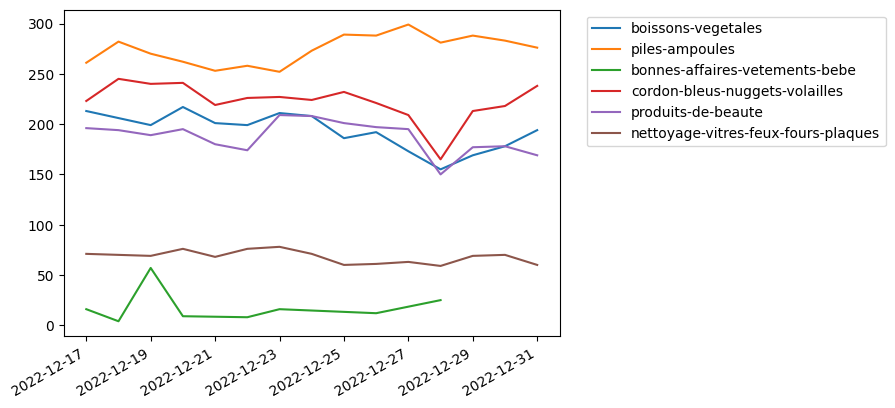

In [59]:
for i in my_categories[0:6]:
    current_category = i.asDict()['category']
    smaller = fer.select("avg(count_not_available)", "formatedDate").filter(col("category") \
                .contains(current_category)) \
                .sort('formatedDate').toPandas()
    plt.plot(smaller['formatedDate'],smaller['avg(count_not_available)'], label=current_category.split("/")[-1])

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.gcf().autofmt_xdate()
plt.show()

### Analysis of out-of-stock products by department

In [54]:
fer = sdf.filter(sdf['productIsAvailable'] == 0) \
    .groupBy("department", "formatedDate") \
    .agg(count("productName").alias("count_not_available")) \
    .groupBy("department","formatedDate").mean("count_not_available")

In [55]:
my_departments = fer.select('department').distinct().collect()

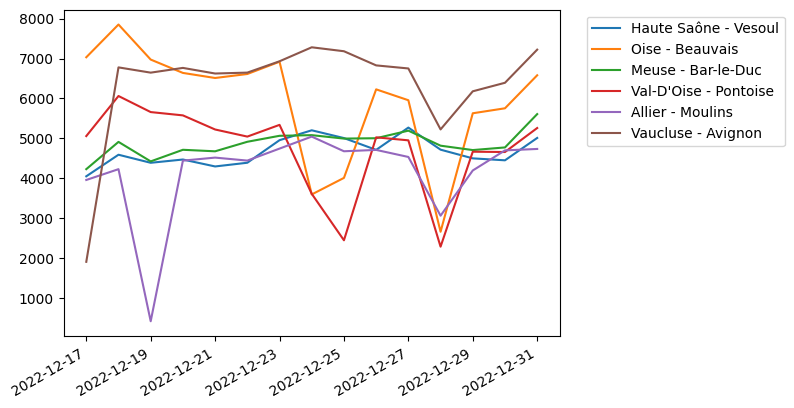

In [56]:
for i in my_departments[0:6]:
    current_department = i.asDict()['department'] 
    smaller = fer.select("formatedDate", "avg(count_not_available)") \
                .filter(col("department") == current_department) \
                .sort('formatedDate').toPandas()
    plt.plot(smaller['formatedDate'], smaller['avg(count_not_available)'], label=france_departments[current_department])

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.gcf().autofmt_xdate()
plt.show()

### Evolution of prices over time by department

In [52]:
fer = sdf.groupBy("department", "formatedDate") \
    .agg(avg("productPrice").alias("avg_price"))
fer

DataFrame[department: string, formatedDate: date, avg_price: double]

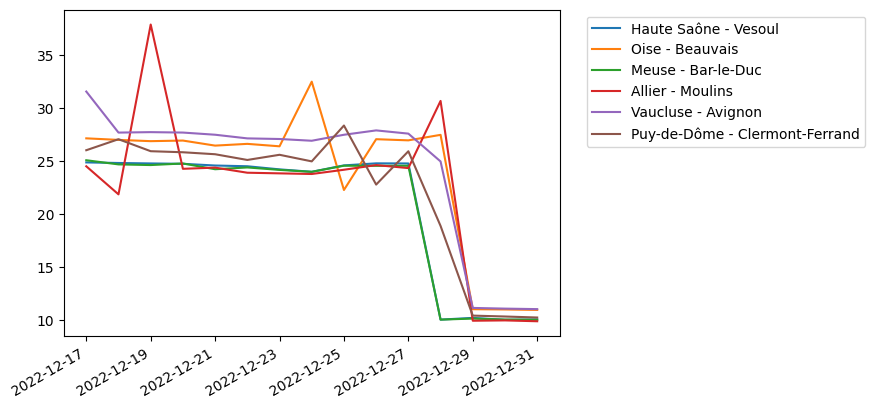

In [53]:
for i in my_departments[0:6]:
    current_department = i.asDict()['department'] 
    smaller = fer.select("formatedDate", "avg_price") \
                .filter(col("department") == current_department) \
                .sort('formatedDate').toPandas()
    plt.plot(smaller['formatedDate'], smaller['avg_price'], label=france_departments[current_department])

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.gcf().autofmt_xdate()
plt.show()

### Market share of customers based on brands

In [39]:
fer = sdf.filter((col("formatedDate") == ps.to_datetime("2022-12-17")) & (col("department") == "69") & (col('category').contains('fruits-legumes/fruits-legumes-pret-a-consommer/legumes-pret-a-consommer') )) \
    .groupBy("productBrand") \
    .count().alias("product_count_by_brand")
fer.show(4)

+-------------+-----+
| productBrand|count|
+-------------+-----+
|   A SAISIR !|    3|
|LES CRUDETTES|    3|
|     CREALINE|   30|
|     FLORETTE|   12|
+-------------+-----+
only showing top 4 rows



In [40]:
pfer = fer.toPandas()

<AxesSubplot: xlabel='productBrand'>

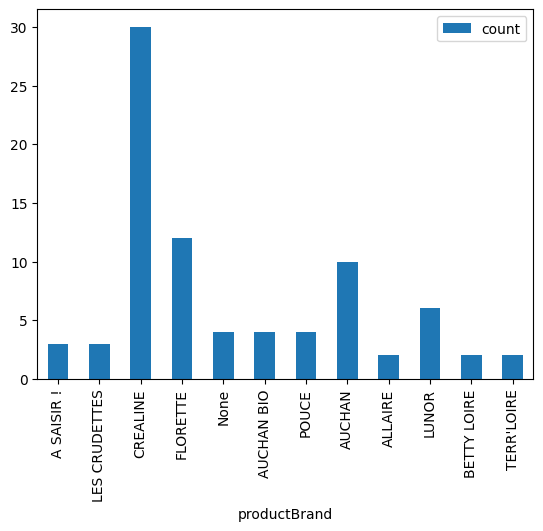

In [41]:
pfer.plot(kind="bar", x='productBrand', y='count')

### Evolution of discounts over time by department

In [49]:
fer = sdf.filter(col("shopID") == "278") \
    .groupBy("productBrand", "formatedDate") \
    .agg(sum("hasDiscount").alias("count_discount"),
        count("hasDiscount").alias("count_total")) \
    .filter(col("count_total") > 100)

fer.show(4)

+--------------------+------------+--------------+-----------+
|        productBrand|formatedDate|count_discount|count_total|
+--------------------+------------+--------------+-----------+
|               APPLE|  2022-12-26|             0|        165|
|AUCHAN LE CHARCUTIER|  2022-12-26|             8|        148|
|              MINNIE|  2022-12-26|             0|        121|
|          GARDENSTAR|  2022-12-26|             7|        182|
+--------------------+------------+--------------+-----------+
only showing top 4 rows



In [50]:
my_brands = fer.select('productBrand').distinct().collect()

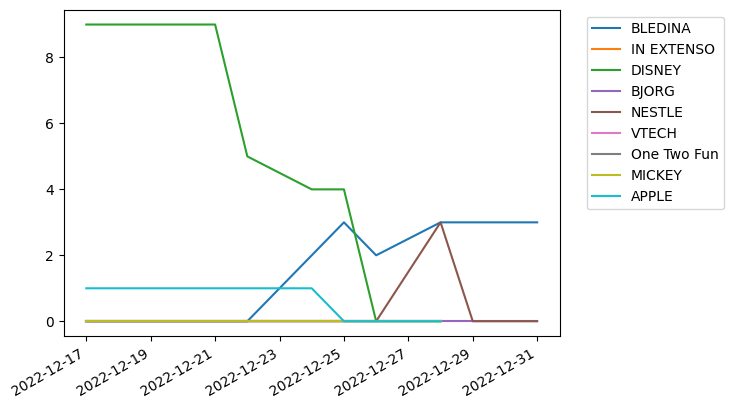

In [51]:
for i in my_brands[0:10]:
    current_brand = i.asDict()['productBrand'] 
    smaller = fer.select("formatedDate", "count_discount") \
                .filter(col("productBrand") == current_brand) \
                .sort('formatedDate').toPandas()
    plt.plot(smaller['formatedDate'], smaller['count_discount'], label=current_brand)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.gcf().autofmt_xdate()
plt.show()

### Which Videogame become more expensive for xmas

In [45]:
games = sdf.select("productPrice", "productName", "formatedDate") \
        .filter(sdf.productName.contains('Nintendo') | sdf.productName.contains('Xbox') | sdf.productName.contains('PS5') | sdf.productName.contains('PS4')) \
        .groupBy('formatedDate', "productName") \
        .avg( "productPrice").alias("avg_price")
games.show(4)

+------------+--------------------+------------------+
|formatedDate|         productName| avg(productPrice)|
+------------+--------------------+------------------+
|  2022-12-20|Horizon : Zero Da...|19.989999771118164|
|  2022-12-20|Let's Sing ABBA N...|  39.9900016784668|
|  2022-12-23|        NBA 2K23 PS4| 24.30034459870437|
|  2022-12-23|Pokémon Diamant E...|  44.9900016784668|
+------------+--------------------+------------------+
only showing top 4 rows



In [46]:
my_games = games.select('productName').distinct().collect()

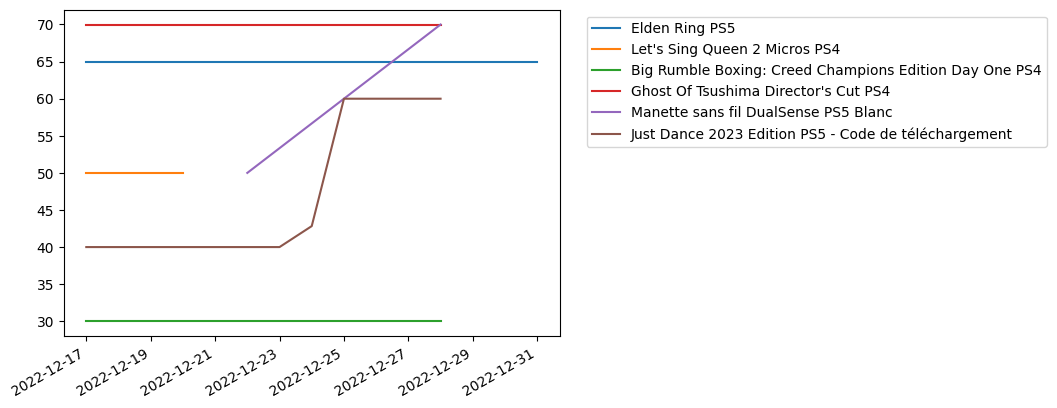

In [48]:
for i in my_games[14:20]:
    current_game = i.asDict()['productName'] 
    smaller = games.select("formatedDate", "avg(productPrice)") \
                .filter(col("productName") == current_game) \
                .sort('formatedDate').toPandas()
    plt.plot(smaller['formatedDate'], smaller['avg(productPrice)'], label=current_game)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.gcf().autofmt_xdate()
plt.show()